In [345]:
import pandas as pd
import time
from datetime import date, timedelta
import numpy as np
from scipy.stats import norm
import scipy.ndimage.filters
import re
import json
import matplotlib.pyplot as plt
import csv 
from helper import * # File containig some helper functions
import os
import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import plugins
import ast
import math
import pickle
import sys

In [ ]:
gaussian_filter1d()

# [Link to interactive visualisation](https://nbviewer.jupyter.org/github/brunowicht/ada_project/blob/master/project/project.ipynb)

<div style="background-color:red;padding:10px;margin:10px;color:white">
**Run cell below to load necessary data**
</div>

In [125]:
print("Loading df_tag...")
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8", low_memory=False)

print("Loading group_hashtags...")
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))

print("Loading dic_tag_days...")
pickle_in = open("../../twitter_dataset/dic_tag_days.pickle","rb")
dic_tag_days = pickle.load(pickle_in)
pickle_in.close()
print("Done")

Loading df_tag...
Loading group_hashtags...
Loading dic_tag_days...
Done


In [166]:
DATASET_BEGIN_DATE = date(2010, 2, 23)
DATASET_END_DATE = date(2016, 9, 16)
DATASET_TOTAL_DAYS = (DATASET_END_DATE - DATASET_BEGIN_DATE).days + 1 # 2398 days in total

2398

# 0. Understanding the dataset

Before starting any kind of data analysis, we first have to review the content of our dataset and understand its meaning better. To do this, we use the data sample and the schema provided with the dataset.

## 0.1. Dataset structure
Let us first read the `schema.txt` file to understand what fields our dataset contains.

In [4]:
schema = pd.read_table('twitter-swisscom/schema.txt', delimiter='    ', engine='python',
                       names=['Field name', 'Type', 'Specification', 'Unsigned', 'Optional field', 'Format'] )
schema

,Field name,Type,Specification,Unsigned,Optional field,Format
1,id,bigint(20),NaN,UNSIGNED,No,None
2,userId,bigint(20),NaN,UNSIGNED,No,None
3,createdAt,timestamp,NaN,NaN,No,0000-00-00 00:00:00
4,text,text,utf8_unicode_ci,NaN,No,None
5,longitude,float,NaN,NaN,Yes,NaN
6,latitude,float,NaN,NaN,Yes,NaN
7,placeId,varchar(25),utf8_general_ci,NaN,Yes,NaN
8,inReplyTo,bigint(20),NaN,UNSIGNED,Yes,NaN
9,source,int(10),NaN,UNSIGNED,No,None
10,truncated,bit(1),NaN,NaN,No,None


The `schema.txt` contains information about each field in our dataset. We see that there are 20 possible fields for a tweet, but many of them are optional, so most tweets probably haver fewer specified field than that.

Here are the fields that will be the most useful:
- userId: to know who posted the tweet
- createdAt: to know when the tweet was posted
- text: content of the tweet
- longitude and latitude: to know from where the tweet was posted


## 0.2. Dataset contents
Now, let us have a look at the actual content of our dataset using the provided sample.

In [ ]:
sample_df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\', 
                        index_col='id', names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')
sample_df.head()

Let us check the percentage of `NaN` values for each field.

In [ ]:
sample_df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/sample_df.shape[0]))

We can observe that the `latitude` and `longitude` are quite often `NaN`, whereas the `placeLatitude`and `placeLongitude` fields are always specified. Therefore, we will use the latter fields.

Let us visualize the geographical distribution of the tweets in the sample dataset.

In [ ]:
swiss_coord = [46.8, 8.2]
swiss_map = folium.Map(swiss_coord, zoom_start=8)
add_markers_to_map_(sample_df.rename(columns={"placeLongitude": "Latitude", "placeLatitude": "Longitude"}), swiss_map, False)

In [ ]:
swiss_map

# 1. Data cleaning and pre-processing

In [5]:
# The only columns we keep before any computation
keep_col = ['id', 'userId', 'createdAt', 'text', 'placeLongitude', 'placeLatitude']

Here we have the script for reading the whole dataset, filter the tags and identification in the text and store everything in a dataframe.  
The function `get_hashtag(text)` takes text, extract the hashtags (all the hashtags have been lowercased because uppercase does not add any information).

In [6]:
df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\',
                 names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')

# We only keep the column we are interested in
df = df[keep_col]

# Extract the hashtags from the text.
df['tag'] = df.text.apply(lambda t: get_hashtags(t))

# We will not use the text anymore, no need to keep it.
df = df.drop(['text'], axis=1)

# Rename latitude and longitute for easier future usage.
df = df.rename(columns={'placeLongitude': 'Longitude', 'placeLatitude': 'Latitude'})
df.head()

,id,userId,createdAt,Longitude,Latitude,tag
0,776522983837954049,735449229028675584,2016-09-15 20:48:01,8.96044,46.0027,[]
1,776523000636203010,2741685639,2016-09-15 20:48:05,8.22414,46.8131,[]
2,776523045200691200,435239151,2016-09-15 20:48:15,5.94082,47.2010,[]
3,776523058404290560,503244217,2016-09-15 20:48:18,6.16552,45.8011,[]
4,776523058504925185,452805259,2016-09-15 20:48:18,6.14319,46.2048,[#geneve]


In [9]:
df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/df.shape[0]))

id           0.00 %
userId       0.00 %
createdAt    0.00 %
Longitude    0.00 %
Latitude     0.00 %
tag          0.00 %
dtype: object

To be able to easily group by day, month or year, we decided to add those three columns to our dataframe, so we can drop the createdAt column which contains also the time (with second precision) of the tweet post, but we will not need it. We still need to set the tweet id as the unique index of tweets to be able to retreive some information in the original dataset if needed.

In [ ]:
df['day'] = df.createdAt.apply(lambda x : x[:10])
df['month'] = df.createdAt.apply(lambda x : x[:7])
df['year'] = df.createdAt.apply(lambda x : x[:4])
df = df.drop(['createdAt'],axis=1)
df = df.set_index('id')

We can then store the resulting dataframe in a new csv file which is around 3 times smaller than the original one. We can then filter tweet that contains at least one hashtag and thos which contains at least one identification to create subdataset as we want to work with hashtags and identifications.

In [ ]:
df.to_csv('../../twitter_dataset/cleaned.csv', sep=';', encoding='utf-8')

In [ ]:
df_tag = df[(df["tag"].astype(str) != '[]')]
df_tag.to_csv('../../twitter_dataset/cleaned_hashtag.csv', sep=';', encoding='utf-8')

# 2. Data Manipulation
## 2.1. Grouping by hashtag

The first step of our descriptive data analysis is to group all tweets by hashtags. In other words, we want to have a dataframe containing for each hashtag the indices of the tweets in which it appears. This will allow us to count find the most popular hashtags, and later agregate them by time.

First, we retrieve our cleaned dataset containing tweets with hashtags by loading it from the file we save in the previous step. This allows us to avoid unnecessary computations.

In [10]:
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8")

/home/davide/anaconda3/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Then we can implement the main function that will group our data by hashtag as described above.

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `get_hashtags(text, lowercase=True)` : Returns the list of all hashtags present in the given text.
- `get_index_with_hashtag(df, hashtag)` : Returns the indices of the tweets in which the given hashtag appears.

In [ ]:
def group_by_hashtag(df):
    """For each hashtag, give the indices of the tweets in which it appears.
    
    df: dataframe to use for the grouping
    load_hashtags_list: if True, loads the list of different hashtags from a file saved previously.
                        if False, computes the hashtag list again.
    """
    
    # Get the indices of the tweets in which each hashtag appears
    output = {}
    for index, item in df.iterrows():
        tags = get_hashtags(item.tag, lowercase=False)
        for tag in tags:
            if(tag in output):
                output_tag = output[tag]
                output_tag[0].append(index)
                output_tag[1].append(item.userId)
            else:
                output[tag] = [[index], [item.userId]]
    
    for tag, lists in output.items():
        output_tag = output[tag]
        output_tag[0] = list(np.unique(np.array(lists[0])))
        output_tag[1] = len(np.unique(np.array(lists[1])))
    
    
    
    # Convert to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx', 'nb_unique_authors']
    return output_df

Then we can actually call this function on our dataset. We store the result in a csv file so that we won't have to compute it again.

In [ ]:
# Compute the groups by hashtag
group_hashtags = group_by_hashtag(df_tag)
group_hashtags = group_hashtags.set_index("hashtag")

# Save result to csv file
group_hashtags.to_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", encoding="utf-8", columns=["tweets_idx", "nb_unique_authors"])

In [11]:
# Read hashtag groups from file
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))
group_hashtags.head()

,tweets_idx,nb_unique_authors
hashtag,,
#instabeautiful,"[359953, 961976, 2067053, 2250249, 2250301]",4
#varrialemaiale,"[1003936, 1753632]",2
#bainschauds,[2273733],1
#minho,"[2473162, 2524797, 2743672]",2
#tescheloucommekanyewest,[1145882],1


We now have for each hashtag of our dataset the indices of the tweets in which it appears. With that data, we can for example see what hashtags were tweeted the most.

In [12]:
# Get the occurence of each hashtag
group_hashtags['tweets_nb'] = group_hashtags['tweets_idx'].apply(lambda ls: len(ls))

# Get the 1510most popular hashtags
group_hashtags.sort_values('tweets_nb', ascending=False).drop(['tweets_idx'], axis=1).head(10)

,nb_unique_authors,tweets_nb
hashtag,,
#switzerland,17347,63364
#lrt,4692,45596
#lt,5306,43009
#newyearrocks,32634,38256
#job,604,33736
#christmasrocks,27426,32530
#zurich,7621,28660
#np,3244,28003
#geneva,5783,26907


# 3. Data Analysis and Visualization

## 3.1. Visualizing hashtag frequency
We want to be able to determine if a certain hashtag has a spike of popularity at a certain time. To do that, we visualize the number of tweets containing a given hashtag per unit of time (day, month, or year)

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `search_hashtag(hashtag, df)` : Filter the given dataset to keep only elements that contain the given hashtag.
- `plot_frequency_tags(df, col, hashtag, n)` : Display a bar plot of the number of tweets with the given hashtag per unit of time given in 'col' (day, month or year) .

For example, let us take a look at the tweets with the hashtag '#jesuischarlie'.

In [17]:
df_Charlie = search_hashtag("#jesuischarlie", df_tag, group_hashtags)
df_Charlie.head(10)

,id,userId,Longitude,Latitude,tag,at,day,month,year
2122726,552805185706545153,23783420,47.3774,8.53676,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122729,552805619062038529,23783420,47.3774,8.53676,"['#journalisten', '#medienfreiheit', '#jesuisc...",[],2015-01-07,2015-01,2015
2122740,552806885053988865,414754156,46.5287,6.65208,"['#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122747,552807441407434752,448198451,46.2048,6.14319,"['#cabu', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122750,552807881012424705,448198451,46.2048,6.14319,"['#jesuischarlie', '#charliehebdo']",[],2015-01-07,2015-01,2015
2122751,552808524020215808,2556353232,47.6206,6.78752,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122753,552808602835369984,448198451,46.2048,6.14319,"['#charb', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122763,552809303636475904,129821394,46.8031,7.15962,"['#jesuischarlie', '#charliehebdo']",['@Charlie_Hebdo_'],2015-01-07,2015-01,2015
2122765,552809353657729024,391267192,46.01,7.3331,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122779,552810466050052096,634553,46.1795,6.14126,"['#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015


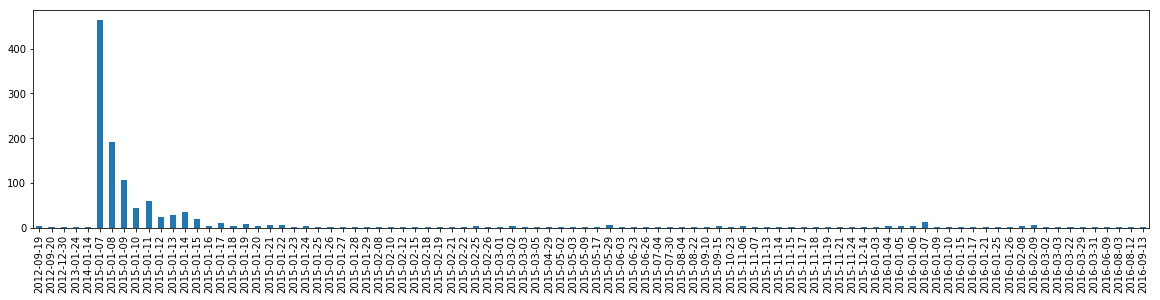

In [18]:
plot_frequency_tags(df_tag, 'day', "#charliehebdo", 100, group_hashtags)

Let us now try this for events that take place every year at the same period, for example Eurovision and Paléo Festival.

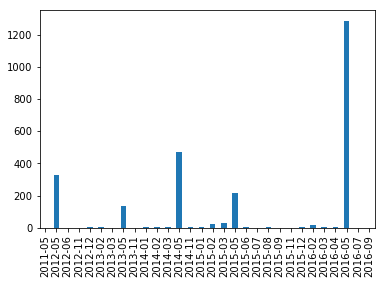

In [19]:
plot_frequency_tags(df_tag, 'month', "#eurovision", 30, group_hashtags)

For Eurovision, we can clearly see a spike each year during the month of may, which is indeed when the contest takes place.

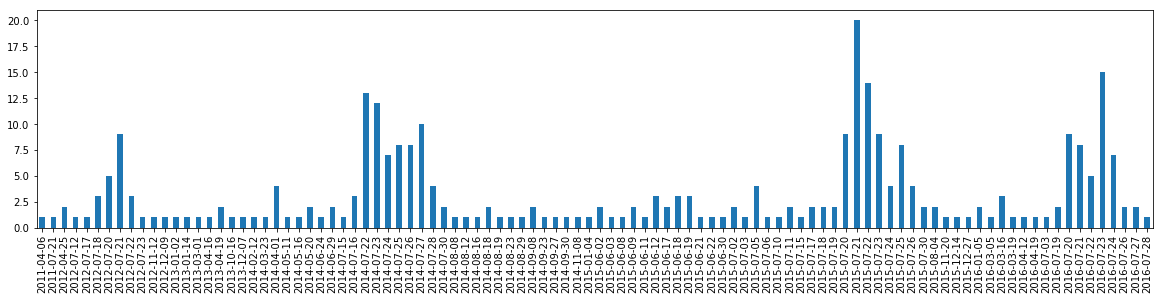

In [20]:
plot_frequency_tags(df_tag, 'day', "#paleo", 100, group_hashtags)

For Paléo Festival, we can again see a spike each year during the end of month of July, but this time we can also see that it lasts about a week.

## 3.2 Geographic event localisation

Here we can use the geographic information of the tweets to determine the location of an event. To do so, we display on a map the geolocation of each tweet that mentions a given hashtag. The following function were implemented in order to create this map.

In [130]:
def popup_html(row):
    """Return the html to create a popup for the dataframe row.
    """
    return """
    <style>
    h3 {
        color: black;
        font-size: 16px;
        text-align: center;
    }
    </style>
    <h3> %s </h3>
    <h3> %s </h3>
    """ %( row.day, str(row.tag.replace("'", "").replace("[", "").replace("]", "")) )

def add_markers_to_map_(dataframe, map_, popup = True, maxClusterRadius = 10):
    """Add the clusters of markers from the dataframe to the given map. 
    """
    popups = []
    coordinates = []
    for index,row in dataframe.iterrows():
        if row.Latitude != '\\N' and row.Longitude != '\\N':
            coordinates.append([float(row.Longitude), float(row.Latitude)])
            if popup:
                popups.append(folium.Popup(popup_html(row)))
            else:
                popups.append("")
            
    marker_cluster = MarkerCluster(locations=coordinates, 
                                   popups=popups).add_to(map_)
           
def get_map_with_hasthtag(hashtag, group_hashtags, dates=None):
    """Create a map with the markers for the given hashtag and (optionally) at the given dates.
    """
    swiss_coord = [46.8, 8.2]
    swiss_map = folium.Map(swiss_coord, zoom_start=8)
    
    # Get the dataframe of the tweet containing the hashtag.
    indexes = group_hashtags.loc[hashtag]
    event_df_tag = df_tag.iloc[indexes[0]]
    
    # If some dates were given, keep only tweets from these dates
    if dates is not None:
        dates_str = [str(d) for d in dates]
        event_df_tag = event_df_tag[event_df_tag['day'].isin(dates_str)] 
    
    add_markers_to_map_(event_df_tag, swiss_map)

    return swiss_map

Now let us try this with Eurovision and Paléo Festival, which were already used as examples previously. As we can see in the maps below, Eurovision is an international event since the geographic repartitions of tweet is quite homogenous over Switzerland. On the other hand, if we look at the hashtag '#paleo', we can quickly see that it takes place in Nyon because there is a very high concentration of tweets about Paléo in that area.

In [ ]:
get_map_with_hasthtag("eurovision", group_hashtags)

In [ ]:
get_map_with_hasthtag("paleo", group_hashtags)

# 4. Event detection

## 1. Filtering out irrelevant hashtags

Currently, we have way too many hashtags and it would be unfeasible run our event detection algorithm on every single one of them. Thus we have to filter out hashtags that are very unlikely to be detected as events by our algorithm.

In [37]:
print("Total number of hashtags : %s" % group_hashtags.shape[0])

Total number of hashtags : 874767


First, we filter our hashtags by keeping only the ones that are used in more than **100** tweets. Then remove hashtags tweeted by less than **50** unique users. By filtering with respect to the number of unique users instead of the total number of tweets, we discard hashtags that were tweeted many times by only a few number of people. This could be the case if one or a few twitter bots tweet some hashtag an insane number of times in a short period.

In [29]:
def get_max_daily_unique_authors(hashtag_dic_days):
    return max(hashtag_dic_days.values())

In [ ]:
group_df_filtered = group_hashtags.copy()
group_df_filtered = group_df_filtered[group_df_filtered['tweets_nb'] > 100]
group_df_filtered = group_df_filtered[group_df_filtered['nb_unique_authors'] > 50]

group_df_filtered['max_unique_author_day'] = group_df_filtered.index.map(lambda hashtag: get_max_daily_unique_authors(dic_tag_days.get(hashtag)))
group_df_filtered[group_df_filtered['max_unique_author_day'] > 5].shape[0]

group_df_filtered.shape[0]

In [ ]:
# Get the list of the hashtag for the event detection.
tag_list = group_df_filtered.index.values
tag_list

In [89]:
def get_unique_author_per_frequency(df, frequency):
    """
        Returns a dictionnary containing for each hashtags a dictionnary of dates
        and the corresponding number of user that has tweeted this hashtag frequency.
        
        df: group_df_filtered
        frequency: one of the following values : {"day", "month", "year"}
    """
    
    print('Computing dictionnary...')
    dic_tag_days = {}
    nb_tags = df.shape[0]
    row_nb = 0
    
    for tag, row in df.iterrows():
        row_nb = row_nb + 1
        grouped_day = df_tag.iloc[row['tweets_idx']]

        grouped_day = grouped_day.drop_duplicates(["userId", frequency], "first")
        dic_tag_days[tag] = grouped_day[frequency].value_counts()
        
        sys.stdout.write("\r{0:.2f}%".format((float(row_nb)/nb_tags)*100))
        sys.stdout.flush()
    
    return dic_tag_days

In [90]:
# Compute dictionnary of hashtags occurences per day
dic_tag_days = get_unique_author_per_day(group_df_filtered, "day")

# Save dictionnary to file
print('\nSaving dictionnary to file...')
pickle_out = open("../../twitter_dataset/dic_tag_days.pickle","wb")
pickle.dump(dic_tag_days, pickle_out)
pickle_out.close()

Computing dictionnary...
100.00%
Saving dictionnary to file...


In [125]:
# Load dictionnary of hashtags occurences per day from file
pickle_in = open("../../twitter_dataset/dic_tag_days.pickle","rb")
dic_tag_days = pickle.load(pickle_in)
pickle_in.close()

## 2. Basic algorithm

In [126]:
def plot_hashtag_occurence_for_dates(hashtag, dic_tag_days, start_date, end_date):
    """Display a bar plot of the number of unique users that
       tweeted the given hashtag between the given dates.
    """
    # Get the total number of days to be displayed
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    # Create the array of string containing every day between the given end and start dates
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    # Get the corresponding nuber of unique users having tweeted the hashtag
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    # Set the label for the xticks
    date_ticks_period = math.ceil(nb_days/50)
    date_ticks = [(dates[i] if i%date_ticks_period==0 else "") for i in range(nb_days)]
    
    # Display the bar plot
    width = 0.5 if (nb_days < 200) else 1.0
    left = [l + (1-width)/2 for l in range(nb_days)]
    plt.figure(figsize=(min(20, nb_days/4),4))
    plt.title(hashtag)
    plt.bar(left, nb_authors, width=width)
    plt.xticks(left, date_ticks, rotation='vertical')
    plt.ylabel("Number of unique users \n that tweeted the hashtag ")
    plt.show()

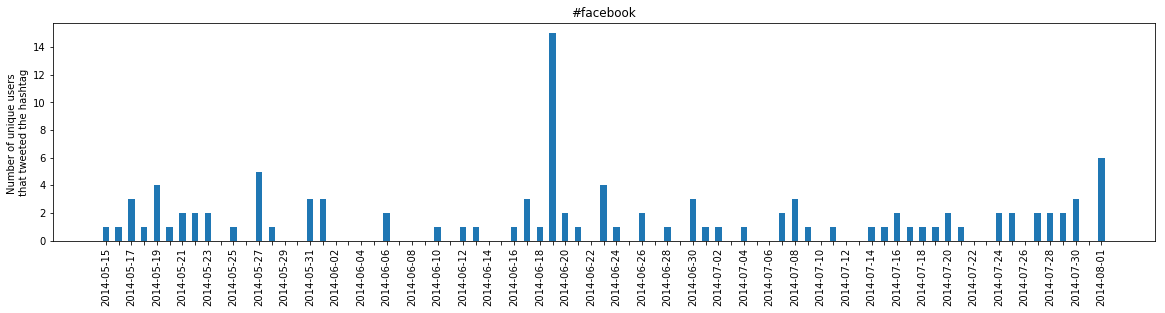

In [159]:
plot_hashtag_occurence_for_dates('#facebook', dic_tag_days, date(2014, 5, 15), date(2014, 8, 1))

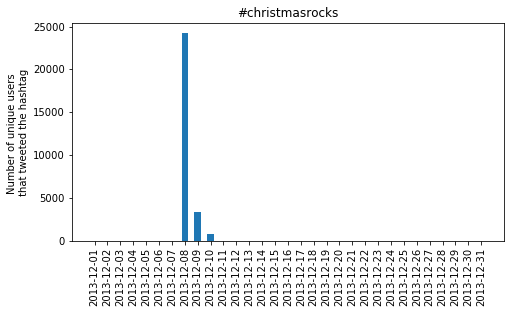

In [160]:
plot_hashtag_occurence_for_dates('#christmasrocks', dic_tag_days, date(2013, 12, 1), date(2013, 12, 31))

In [473]:
def get_average(hashtag, dic_tag_days, start_date, end_date):
    """Returns the average number of unique authors of the given hashtag between the given dates.
    """
    # Get the total number of days to be displayed
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    # Create the array of string containing every day between the given end and start dates
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    # Get the corresponding number of unique users having tweeted the hashtag
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    mean = np.mean(nb_authors)
    return mean

def get_event_score(day, dic_hashtag, moving_avg, event_kernel, max_factor=2):
    """Returns the event score for a given day.
       This is obtained by innerproduct between the number of unique authors and the given kernel, 
       and then dividing by the given moving average (which is an average over values around that day).
    """
    # Get the number of unique authors for the given day
    day_value = dic_hashtag.get(str(day), 0)
    
    # If no tweets that day, the score is 0
    if day_value == 0:
        event_score = 0
    else:
        # Compute the inner product of the values with the given kernel centered around the day of interest
        h = int(len(event_kernel) / 2)
        event_inner_prod = 0
        for i in range(-h, h+1):
            d = day + timedelta(i)
            # For the inner product, we limit the values used to max_factor*day_value
            value_i = min(max_factor*day_value, dic_hashtag.get(str(d), 0))
            event_inner_prod += event_kernel[i + h] * min(max_factor*day_value, dic_hashtag.get(str(d), 0))
        
        # Divide the innerproduct by the moving average to get the event score
        event_score = event_inner_prod / max(1, moving_avg)
    
    return event_score

def my_detect_event(hashtag, dic_tag_days, threshold=4, averaging_window=35):
    """Detect potential events related to the given hashtag. 
       Returns the detected event dates, and an array of event scores for each day in the dataset.
    """
    event_kernel = [0.1, 0.8, 0.1]
    dic_hashtag = dic_tag_days.get(hashtag)
    
    # Create the array containing every day included in the dataset
    dates = np.asarray([DATASET_BEGIN_DATE + timedelta(days=i) for i in range(DATASET_TOTAL_DAYS)])
    
    # Compute the the average and variance for the first moving window
    moving_avg_window_end = DATASET_BEGIN_DATE + timedelta(days=averaging_window - 1)
    moving_avg = get_average(hashtag, dic_tag_days, DATASET_BEGIN_DATE, moving_avg_window_end)
    half_window = int(averaging_window / 2)
        
    # Compute the event score for each day
    event_score = np.zeros(len(dates)) 
    for i in range(half_window, len(dates) - half_window):
        if i != half_window:
            moving_avg_update = (dic_hashtag.get(str(dates[i+half_window]),0) - dic_hashtag.get(str(dates[i-half_window-1]),0)) / averaging_window
            moving_avg = moving_avg + moving_avg_update
        
        event_score[i] = get_event_score(dates[i], dic_hashtag, moving_avg, event_kernel)
        
    # Get the dates at which an event was detected
    event_dates = dates[np.where(event_score >= threshold)]
    event_dates = [str(d) for d in event_dates]
    
    return (event_dates, event_score)

In [470]:
import timeit
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

wrapped = wrapper(my_detect_event, "#facebook", dic_tag_days)
timeit.timeit(wrapped, number=100)/100

0.037081323589663956

In [449]:
dates = np.asarray([str(DATASET_BEGIN_DATE + timedelta(days=i)) for i in range(DATASET_TOTAL_DAYS)])

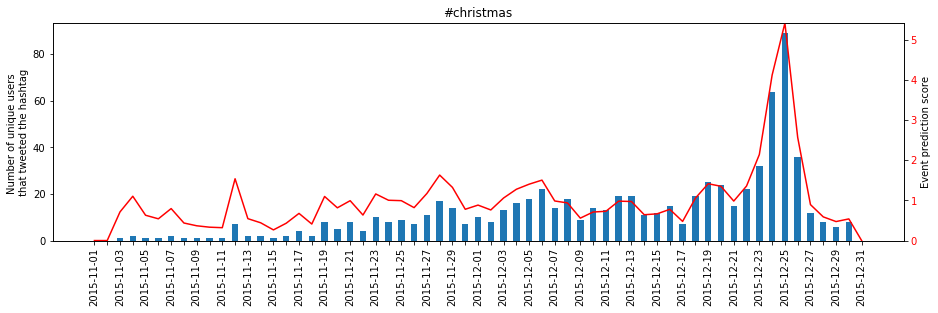

['2012-12-24',
 '2012-12-25',
 '2013-12-24',
 '2013-12-25',
 '2014-12-24',
 '2014-12-25',
 '2015-12-24',
 '2015-12-25']

In [477]:
hashtag = "#christmas"
(event_dates, event_score) = my_detect_event(hashtag, dic_tag_days)
plot_hashtag_and_event_prediction(hashtag, event_score, dic_tag_days, date(2015, 11, 1), date(2015, 12, 31))
event_dates

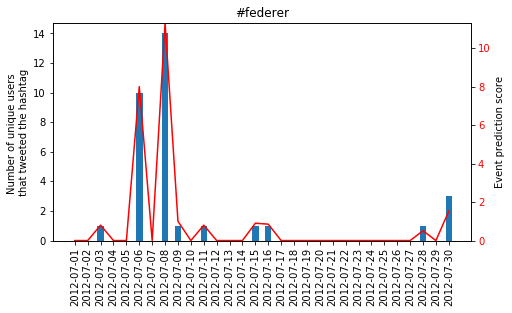

['2012-07-06',
 '2012-07-08',
 '2012-08-03',
 '2012-08-05',
 '2012-11-11',
 '2012-11-12',
 '2013-01-17',
 '2013-01-23',
 '2013-01-25',
 '2013-06-02',
 '2013-06-04',
 '2013-06-26',
 '2014-01-22',
 '2014-01-24',
 '2014-04-20',
 '2014-05-06',
 '2014-07-06',
 '2014-09-06',
 '2014-11-23',
 '2014-11-24',
 '2015-07-10',
 '2015-07-12',
 '2015-08-23',
 '2015-09-13',
 '2015-09-14',
 '2015-11-01',
 '2016-01-28',
 '2016-07-06',
 '2016-07-08']

In [478]:
hashtag = "#federer"
(event_dates, event_score) = my_detect_event(hashtag, dic_tag_days)
plot_hashtag_and_event_prediction(hashtag, event_score, dic_tag_days, date(2012, 7, 1), date(2012, 7, 30))
event_dates

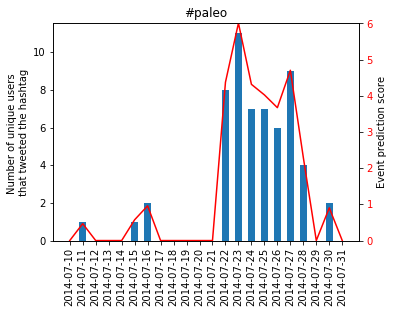

['2014-07-22',
 '2014-07-23',
 '2014-07-24',
 '2014-07-25',
 '2014-07-27',
 '2015-07-20',
 '2015-07-21',
 '2015-07-22',
 '2015-07-23',
 '2016-07-20',
 '2016-07-23',
 '2016-07-24']

In [479]:
hashtag = "#paleo"
(event_dates, event_score) = my_detect_event(hashtag, dic_tag_days)
plot_hashtag_and_event_prediction(hashtag, event_score, dic_tag_days, date(2014, 7, 10), date(2014, 7, 31))
event_dates

In [418]:
def plot_hashtag_and_event_score(hashtag, event_score, dic_tag_days, start_date, end_date):
    """Display a bar plot of the number of unique users that tweeted the given hashtag
       between the given dates, and the computed event score on top.
    """
    # Get the total number of days to be displayed
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    # Get the relevant portion of the event prediction
    start_day_index = (start_date - DATASET_BEGIN_DATE).days
    event_score = event_score[start_day_index : start_day_index + nb_days]
    
    # Create the array of string containing every day between the given end and start dates
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    # Get the corresponding nuber of unique users having tweeted the hashtag
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    # Set the label for the xticks
    date_ticks_period = math.ceil(nb_days/50)
    date_ticks = [(dates[i] if i%date_ticks_period==0 else "") for i in range(nb_days)]
    
    # Display the bar plot
    width = 0.5 if (nb_days < 200) else 1.0
    left = [l + (1-width)/2 for l in range(nb_days)]
    
    fig, ax1 = plt.subplots(figsize=(min(20, nb_days/4),4))
    plt.title(hashtag)
    ax2 = ax1.twinx()

    ax1.bar(left, nb_authors, width=width)
    ax1.set_ylabel('Number of unique users \n that tweeted the hashtag ')
    ax1.set_xticks(left)
    ax1.set_xticklabels(date_ticks, rotation=90)
    
    ax2.plot(left, event_score, 'r-')
    ax2.set_ylabel('Event prediction score')
    ax2.set_ylim(0, max(1, event_score.max()))
    for t in ax2.get_yticklabels():
        t.set_color('r')

    plt.show()

## 3. Algorithm Optimization

In [161]:
days = list(set(df_tag.day.values.tolist()))
months = list(set(df_tag.month.values.tolist()))
days.sort()
months.sort()
len(months)

86

In [164]:
days

['1994-04-04',
 '1994-12-07',
 '1995-12-25',
 '1996-06-18',
 '2003-05-19',
 '2004-06-10',
 '2007-02-27',
 '2007-09-07',
 '2010-02-23',
 '2010-02-24',
 '2010-02-25',
 '2010-02-26',
 '2010-02-27',
 '2010-02-28',
 '2010-03-01',
 '2010-03-02',
 '2010-03-03',
 '2010-03-04',
 '2010-03-05',
 '2010-03-06',
 '2010-03-07',
 '2010-03-08',
 '2010-03-09',
 '2010-03-10',
 '2010-03-11',
 '2010-03-12',
 '2010-03-13',
 '2010-03-14',
 '2010-03-15',
 '2010-03-16',
 '2010-03-17',
 '2010-03-18',
 '2010-03-19',
 '2010-03-20',
 '2010-03-21',
 '2010-03-22',
 '2010-03-23',
 '2010-03-24',
 '2010-03-25',
 '2010-03-26',
 '2010-03-27',
 '2010-03-28',
 '2010-03-29',
 '2010-03-30',
 '2010-03-31',
 '2010-04-01',
 '2010-04-02',
 '2010-04-03',
 '2010-04-04',
 '2010-04-05',
 '2010-04-06',
 '2010-04-07',
 '2010-04-08',
 '2010-04-09',
 '2010-04-10',
 '2010-04-11',
 '2010-04-12',
 '2010-04-13',
 '2010-04-14',
 '2010-04-15',
 '2010-04-16',
 '2010-04-17',
 '2010-04-18',
 '2010-04-19',
 '2010-04-20',
 '2010-04-21',
 '2010-04-

In [155]:
def get_yesterday(day, days):
    "find the the yesterday of day in list days"
    idx = days.index(day)
    if idx == 0:
        return day
    return days[idx - 1]

def get_tomorrow(day, days):
    "find the tomorrow of day in list days"
    idx = days.index(day)
    if idx == len(days) - 1:
        return day
    return days[idx + 1]

def get_next_month(month, months):
    idx = months.index(month)
    if idx == len(months) - 1:
        return month
    return months[idx + 1]

def get_last_month(month, months):
    idx = months.index(month)
    if idx == 0:
        return month
    return months[idx - 1]

In [156]:
def tag_on_day(day, dico):
    try:
        return dico[day]
    except:
        return 0
    
def detect_day_event(tag, df, days, grouped_tag, authors_per_day, k = 10):
    dico = authors_per_day[tag]
    event_days = list()
    for d in days:
        y_nb = tag_on_day(get_yesterday(d, days), dico)
        t_nb = tag_on_day(get_tomorrow(d, days), dico)
        nb = tag_on_day(d, dico)
        if (y_nb != 0 and y_nb * k <= nb) :
            event_days.append(d)
        elif (t_nb != 0 and t_nb * k <= nb):
            event_days.append(d)
        elif (y_nb == 0 and nb >= k):
            event_days.append(d)

    return event_days

def tag_per_month(tag, df, grouped_tag):
    df_t = search_hashtag(tag, df, grouped_tag)
    dico = dict(df_t["month"].value_counts())
    return dico

def tag_on_month(month, dico):
    try:
        return dico[month]
    except:
        return 0
    
def detect_month_event(tag, df, months, grouped_tag, k = 10):
    dico = tag_per_month(tag, df, grouped_tag)
    event_months = list()
    for m in months:
        l_nb = tag_on_month(get_last_month(m, months), dico)
        n_nb = tag_on_month(get_next_month(m, months), dico)
        nb = tag_on_month(m, dico)
        if (l_nb != 0 and l_nb * k <= nb) :
            event_months.append(m)
        elif (n_nb != 0 and n_nb * k <= nb):
            event_months.append(m)
        elif (l_nb == 0 and nb >= k):
            event_months.append(m)
    events = list()
    for e in event_months:
        data = search_hashtag(tag, df, grouped_tag)
        v = tag_on_month(e, dico) * 1.
        r = data[data.month == e].userId.value_counts()[:1].values[0]
        events.append(e)
        
    return events

In [157]:
detect_day_event("#startups", df_tag, days, group_hashtags, dic_tag_days, k = 3)

['2014-02-04',
 '2014-02-06',
 '2014-03-22',
 '2014-04-02',
 '2014-06-18',
 '2014-10-30',
 '2015-08-25',
 '2015-10-29',
 '2015-11-13',
 '2015-11-25',
 '2016-01-13',
 '2016-02-10',
 '2016-03-17',
 '2016-03-22',
 '2016-03-31',
 '2016-04-12',
 '2016-04-28',
 '2016-05-02',
 '2016-06-20',
 '2016-09-14']

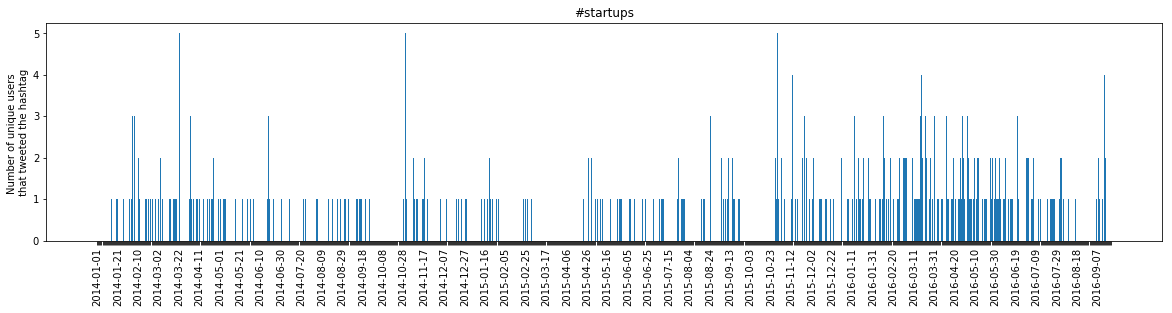

In [160]:
plot_hashtag_occurence_for_dates('#startups', dic_tag_days, date(2014, 1, 1), date(2016, 9, 20))

In [61]:
def detect_events(tags, df_tag, days, months, grouped_tag, k_month, k_day):
    days_events = dict()
    months_events = dict()
    for t in tags:
        d = detect_day_event(t, df_tag, days, grouped_tag, k=k_day)
        m = detect_month_event(t, df_tag, months, grouped_tag, k=k_month)
        if d:
            days_events[t] = d
        elif m:
            months_events[t] = m
    return days_events, months_events
    

In [ ]:
t = time.time()
print(len(tag_list))
d,m = detect_events(tag_list, df_tag, days, months, group_hashtags, 100,100)
print(time.time() - t)

In [ ]:
print(len(m))
print(len(d))
#125/107

In [ ]:
d

In [ ]:
m

In [ ]:
detect_day_event("#riprobinwilliams", df_tag, days, k=40)

In [ ]:
plot_hashtag_occurence_for_dates('#ff', dic_tag_days, date(2014, 1, 1), date(2014, 5, 31))

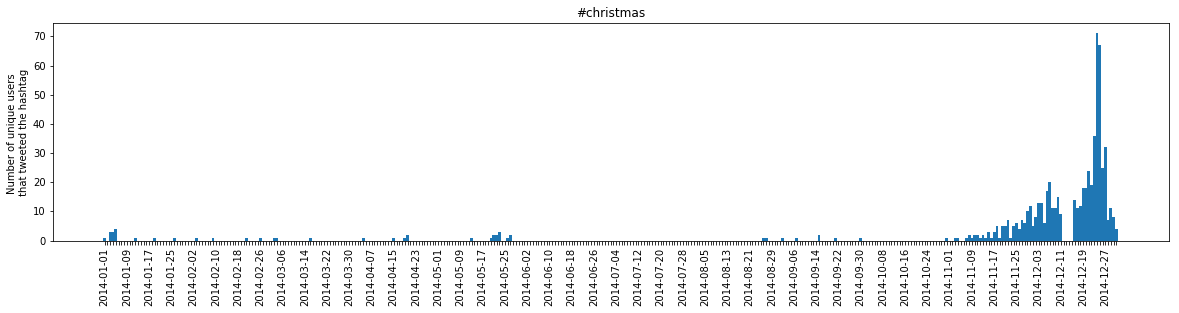

In [136]:
plot_hashtag_occurence_for_dates('#christmas', dic_tag_days, date(2014, 1, 1), date(2014, 12, 31))

In [ ]:
plot_frequency_tags(df_tag, 'day', "#1", 100, group_hashtags)

## 4. Event localisation

In [152]:
def get_event_location(hashtag, dates):
    """Returns the estimated event location, and the mean deviation from that location,
        as well as the mean deviation from the event location.
       The event location is obtained by the median location of all tweets 
       with the given hashtag tweeted in the given dates.
    """
    # convert dates to string
    dates_str = [str(d) for d in dates]
    
    # Get the tweets indices of the hashtag
    tweets_idx = group_hashtags.get_value(hashtag, 'tweets_idx')
    
    # Keeep only the tweets from the given dates
    event_df = df_tag.iloc[tweets_idx]
    event_df = event_df[event_df['day'].isin(dates_str)] 
    if event_df.size == 0:
        raise ValueError('No tweets found for the given dates.')
    
    # Get the estimated event location using the median
    event_location = event_df[['Longitude', 'Latitude']].median().values
    print(event_location)
    
    # Compute the mean deviation from the event location
    df_deviation = event_df[['Longitude', 'Latitude']].applymap(lambda x: float(x))
    df_deviation['Longitude'] = abs(df_deviation['Longitude'] - event_location[0])
    df_deviation['Latitude'] = abs(df_deviation['Latitude'] - event_location[1])
    mean_deviation = df_deviation.mean().values.max()
    
    return (event_location, mean_deviation)

def display_event_map(hashtag, dates, group_hashtags):
    """Returns a map containing all tweets with the given hashtag at the given dates,
       and the estimated event location.
    """
    # Get the estimated event location and mean deviation
    (event_location, mean_deviation) = get_event_location(hashtag, dates)
    print("Detected event location : {}\nMean deviation : {}".format(event_location, mean_deviation))
    
    # Create the map and return it
    my_map = get_map_with_hasthtag(hashtag, group_hashtags, dates=dates)
    folium.CircleMarker(event_location, popup='Detected event location', color='#ff0000', fill_color='#ff0000').add_to(my_map)
    return my_map

In [133]:
hashtag = '#paleo'
dates = [date(2016, 7, 19), date(2016, 7, 20), date(2016, 7, 21), date(2016, 7, 22), date(2016, 7, 23)]
display_event_map(hashtag, dates, group_hashtags)

Detected event location : [ 46.4205    6.19475]
Mean deviation : 0.020771794871794105


In [134]:
hashtag = '#riprobinwilliams'
dates = [date(2014, 8, 12)]
display_event_map(hashtag, dates, group_hashtags)

Detected event location : [ 46.2956    8.53676]
Mean deviation : 1.1133532124352328


In [154]:
hashtag = '#christmas'
dates = [date(2014, 12, 24), date(2014, 12, 25)]
display_event_map(hashtag, dates, group_hashtags)

[ 46.4927    7.72704]
Detected event location : [ 46.4927    7.72704]
Mean deviation : 1.0794126035502956
